# Analyzing Goodness Ratings from Explanations Data

In [1]:
import numpy as np
import pandas as pd
import json 
import os
import sys
import random
import math
import matplotlib.pylab as plt 
import seaborn as sns
import scipy.stats as stats
from matplotlib.font_manager import FontProperties
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import itertools

In [2]:
def parse_rating(rating_str): 
    # cognition.run saves all data as strings
    # need to parse dictionary from a string
    # returns an int
    rating = rating_str.split(":")[-1].split("}")[0]
    return int(rating)

import os
save_dir = "./results/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
data_pth = "../data/goodness_ratings/human_rated_goodness.csv"
df = pd.read_csv(data_pth)
         
# extract subj ids
all_subjs = set(df.PROLIFIC_PID)

print("Num subjs: ", len(all_subjs), ", Num rows: ", len(df))

typicality_data = pd.read_csv("./explanation_typicality.csv", usecols=["Scenario", "Freq X", "Freq X Given Y"])
rating_col = "Freq X"


In [4]:
# filter out to only include the ratings
# e.g., any response that was of type "rate_goodness" 
rating_df = df[(df.task == "rate_goodness")].reset_index()
# gather all goals
all_goals = set(rating_df.prompt)
print("Num goals: ", len(all_goals), " rating df: ", len(rating_df))
# keep only the first rating for people who saw a duplicate plan (due to accidental repeated planner)
for subj_id in all_subjs:
    
    subj_df = rating_df[rating_df.PROLIFIC_PID == subj_id]
    rated_plans = set()
    for idx, plan in zip(subj_df.index, subj_df.plan): 
        if plan in rated_plans: rating_df = rating_df.drop(idx)
        else: rated_plans.add(plan)
rating_df.columns

Num goals:  84  rating df:  10920


Index(['level_0', 'index', 'run_id', 'condition', 'view_history', 'rt',
       'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'PROLIFIC_PID', 'STUDY_ID', 'SESSION_ID', 'subject_id', 'study_id',
       'session_id', 'response', 'question_order', 'prompt', 'task', 'subj_id',
       'plan', 'goal_type', 'stimulus', 'recorded_at', 'ip', 'user_agent',
       'device', 'browser', 'browser_version', 'platform', 'platform_version',
       'source_code_version'],
      dtype='object')

## Extract mean, median, and all goodness ratings for GPT-3 and Human for each Constraint Level

In [5]:
json.loads(rating_df.response.iloc[0])['goodness']
subj_df.index

Int64Index([8580, 8581, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590,
            8591, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601,
            8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612,
            8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621, 8622, 8623,
            8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634,
            8635, 8636, 8637, 8638, 8639],
           dtype='int64')

In [6]:
rating_df.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            10910, 10911, 10912, 10913, 10914, 10915, 10916, 10917, 10918,
            10919],
           dtype='int64', length=10908)

In [7]:
from scipy import stats
rating_data = {}

sources = ["gpt-3", "human"]
constraints = ['unconstrained', 'single-constraint', 'all-constraints']

z_score = False
num_responses = len(rating_df.response)
# rating_df["goodness_rating"] = np.zeros([num_responses,1], dtype=int)
goodness_ratings = []

if z_score == True: 
    # normalize w/in subjs (okay to assume b/c assumed large enough for representative sample)
    scaled_dfs = []
    for subj_id in all_subjs: 
        subj_df = rating_df[rating_df.PROLIFIC_PID == subj_id]
        # extract ratings
        subj_ratings = np.array([json.loads(rating_str)['goodness'] + 1 for rating_str in subj_df.response])
        # run z score
        scaled_ratings = stats.zscore(subj_ratings)
        subj_df["goodness_rating"] = scaled_ratings
        scaled_dfs.append(subj_df)
    rating_df = pd.concat(scaled_dfs, ignore_index=True)
        # map back in the original data frame the new scaled rating
#         orig_idxs = list(subj_df.index)
#         for orig_idx, scaled_rating in zip(orig_idxs, scaled_ratings): 
#             goodness_ratings[orig_idx] = scaled_rating
        
else: 
    for idx, rating_str in enumerate(rating_df.response): 
        if idx > 10900: print(idx, rating_str, json.loads(rating_str)['goodness'] + 1)
#         rating_df["goodness_rating"][idx] = json.loads(rating_str)['goodness'] + 1
        goodness_ratings.append(json.loads(rating_str)['goodness'] + 1)
    rating_df["goodness_rating"] = goodness_ratings
        

for source in sources: 
    if source == "human": df_subset = rating_df[rating_df.subj_id == "human"]
    else: df_subset = rating_df[rating_df.subj_id == "gpt-3"]
    goal_rating_data = {}
    for constraint in constraints:
        if constraint not in goal_rating_data:
            goal_rating_data[constraint] = {}
        constraint_df = df_subset[df_subset.goal_type == constraint]
        
#         ratings = [json.loads(rating_str)['goodness'] + 1 for rating_str in constraint_df.response]
        ratings = list(constraint_df["goodness_rating"])
        avg_goodness = np.mean(ratings)
        median_goodness = np.median(ratings)
        
        
        goal_rating_data[constraint] = {'mean': avg_goodness, 'median': median_goodness, 'ratings': ratings}

    rating_data[source] = goal_rating_data



10901 {"goodness":4} 5
10902 {"goodness":5} 6
10903 {"goodness":4} 5
10904 {"goodness":5} 6
10905 {"goodness":4} 5
10906 {"goodness":5} 6
10907 {"goodness":4} 5


In [8]:
# get summary scores for each explanation 
grouped_data = {}
num_generations = {source: 0 for source in sources}
stimuli_per_cond = {constraint: [] for constraint in constraints}
data_per_goal = {source: {} for source in sources}

for source in sources: 
    source_rating_data = {constraint: [] for constraint in constraints}
    df_subset = rating_df[rating_df.subj_id == source]
    goal_rating_data = {}
    for constraint in constraints:
        constraint_df = df_subset[df_subset.goal_type == constraint]
        
        if len(stimuli_per_cond[constraint]) == 0: stimuli_per_cond[constraint] = sorted(set(constraint_df.prompt))
            
        generations = set(constraint_df["plan"])
        num_generations[source] += len(generations)
        for generation in generations: 
            generation_df = constraint_df[constraint_df.plan == generation]
            prompt = list(generation_df.prompt)[0] # same prompt for all generations, so just take the first
            ratings = [json.loads(rating_str)['goodness'] + 1 for rating_str in generation_df.response]
            avg_goodness = np.mean(ratings)
            median_goodness = np.median(ratings)
            
            obj = {'generation': generation, 'stimuli': prompt, 'mean': avg_goodness, 'median': median_goodness, 'ratings': ratings,
                  "constraint":constraint}
            
            source_rating_data[constraint].append(obj)
            if prompt not in data_per_goal[source]: data_per_goal[source][prompt] = [obj]
            else: data_per_goal[source][prompt].append(obj)
    grouped_data[source] = source_rating_data

In [9]:
typicality_data = typicality_data.sort_values(by=[rating_col])
sorted_goals = list(typicality_data["Scenario"])

midpoint = int(len(sorted_goals)/2)
most_typical = sorted_goals[:int(len(sorted_goals)/2)]
least_typical = sorted_goals[int(len(sorted_goals)/2):]

most_typical, least_typical

(['If a door is locked with a bolt, then it cannot be opened. But suppose a door is locked with a bolt, and then it is opened.',
  'If water is put in the freezer, then it turns into ice. But suppose water is put in the freezer, and then it does not turn into ice.',
  'If someone turns on a bathtub tap, then a bathtub fills with water. But suppose someone turns on a bathtub tap, and then the bathtub does not fill with water.',
  'If it rains over grass, then the grass becomes wet. But suppose it rains, and then the grass does not become wet.',
  'If a light is unplugged, then the light cannot turn on. But suppose a light is unplugged, and then the light can turn on.',
  'If someone drinks lots of coffee , then they have trouble sleeping. But suppose someone drinks lots of coffee, and then they have do not have trouble sleeping.',
  'If plants are not watered, then they die. But suppose plants are not watered, and then they do not die.',
  'If a cymbal is hit with a drum stick, then it 

In [13]:
# extract generations for specific representative stimuli 
sample_data = {constraint: {} for constraint in constraints} 
sample_goal = "If plants are not watered, then they die"
for source in sources: 
    for goal, goal_data in data_per_goal[source].items(): 
        if sample_goal in goal: 
            constraint = goal_data[0]["constraint"]
            
            print(f"\nConstraint: {constraint}, Source: {source} \n{goal}")
            # sort generations by mean rating
            means = [(plan_data["mean"], plan_data["generation"]) for plan_data in goal_data]
            means = sorted(means, key=lambda x: x[0])
            
            middle = int(len(means)/2)
#             print("\n\tMiddle: ", means[int(len(means)/2)], "\n")
            samples = means[middle-4:middle+4]
            for sample in samples: 
                print("\t",sample)
            
            sample_data[constraint][source] = means





Constraint: unconstrained, Source: gpt-3 
Scenario: If plants are not watered, then they die. But suppose plants are not watered, and then they do not die.
	 (5.0, 'This could have happened because they were watered yesterday.')
	 (5.0, 'This could have happened because the plants had been previously watered.')
	 (5.0, 'This could have happened because they were watered yesterday, and they will not die until tomorrow.')
	 (5.333333333333333, 'This could have happened because the plants were genetically modified to be drought resistant.')
	 (5.333333333333333, 'This could have happened because the plants were planted in a drought-resistant variety.')
	 (5.333333333333333, 'This could have happened because the plants were in a room with a humidifier.')
	 (5.666666666666667, 'This could have happened because the plants were growing in a place where there was plenty of water.')
	 (5.666666666666667, 'This could have happened because they are cacti.')

Constraint: single-constraint, Source

In [11]:
source = "gpt-3"
constraint = "all-constraints"
sample_data[constraint][source], sample_data[constraint][source][9:11]

([(1.0,
   'This could have happened because the plants were not watered because they were being held hostage by a plant-waterer.'),
  (1.3333333333333333,
   'This could have happened because the plants were already dead.'),
  (1.3333333333333333,
   'This could have happened because the plants were replaced by robots.'),
  (2.3333333333333335,
   'This could have happened because the plants were being watered by a robotic sprinkler system.'),
  (2.6666666666666665,
   'This could have happened because there is a man who comes by every day to water the plants.'),
  (2.6666666666666665,
   'This could have happened because the plants are made of plastic, and require no water.'),
  (2.6666666666666665,
   'This could have happened because the plants were watered by a drip system that was not turned off.'),
  (2.6666666666666665,
   'This could have happened because the plants were not actually real.'),
  (2.6666666666666665,
   'This could have happened because the plants were actually 

In [10]:
num_generations

{'gpt-3': 1678, 'human': 840}

In [14]:
# save out the best and worst generations
stat = "mean"
threshold = 2
for source in sources: 
    filepth = f"{save_dir}/bad_explanations_{source}.txt"
    f = open(filepth, 'w')
    f.write("Worst Explanations (Mean Likert < 2)\n")
    count = 0
    for constraint in constraints: 
        f.write(f"\nConstraint Type: {constraint} \n")
        for datum in grouped_data[source][constraint]: 
            rating = datum[stat]
            if rating < threshold: 
                f.write(f"\n{datum['stimuli']}")
                f.write(f"\tGeneration: {datum['generation']}")
                f.write(f"\tMedian Rating: {datum['median']}")
                f.write(f"\tMedian Rating: {datum['mean']}")
                f.write(f"\tAll Ratings: {datum['ratings']}")
                count += 1
    print(f"{source}, {round((count/num_generations[source])*100, 2)}% bad")

gpt-3, 9.89% bad
human, 2.02% bad


In [15]:
# save out the best and worst generations
stat = "mean"
threshold = 6
for source in sources: 
    filepth = f"{save_dir}/good_explanations_{source}.txt"
    f = open(filepth, 'w')
    f.write("Best Explanations (Mean Likert > 6)\n")
    count = 0
    for constraint in constraints: 
        f.write(f"\nConstraint Type: {constraint} \n")
        for datum in grouped_data[source][constraint]: 
            rating = datum[stat]
            if rating > threshold: 
                f.write(f"\n{datum['stimuli']}")
                f.write(f"\tGeneration: {datum['generation']}")
                f.write(f"\tMedian Rating: {datum['median']}")
                f.write(f"\tMedian Rating: {datum['mean']}")
                f.write(f"\tAll Ratings: {datum['ratings']}")
                count += 1
    print(f"{source}, {round((count/num_generations[source])*100, 2)}% good")

gpt-3, 3.69% good
human, 3.33% good


In [16]:
# # save out the best and worst generations
# stat = "mean"
# threshold = 2
# for source in sources: 
#     count = 0
#     for constraint in constraints: 
#         print(f"\nConstraint Type: {constraint} \n")
#         for datum in grouped_data[source][constraint]: 
#             rating = datum[stat]
#             if rating < threshold: 
#                 print("\n" + datum["stimuli"])
#                 print("\tGeneration: ", datum["generation"])
#                 print("\tMedian Rating: ", datum["median"])
#                 print("\tMedian Rating: ", datum["mean"])
#                 print("\tAll Ratings: ", datum["ratings"])
#                 count += 1
#     print(f"{source} proportion bad: {(count/num_generations[source])*100}")

In [17]:
count/840

0.03333333333333333

In [18]:
(count/num_generations[source])*100

3.3333333333333335

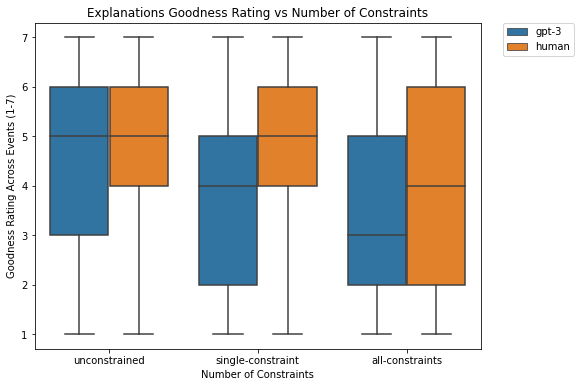

In [19]:
ratings = []
data = grouped_data
for constraint in constraints:
    for source in grouped_data:
        for generation_data in grouped_data[source][constraint]:
            for r in generation_data["ratings"]:
                row = [constraint, source, r]
                ratings.append(row)
    
rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df)
ax.set(ylabel='Goodness Rating Across Events (1-7)', title='Explanations Goodness Rating vs Number of Constraints')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)                                         
                                           

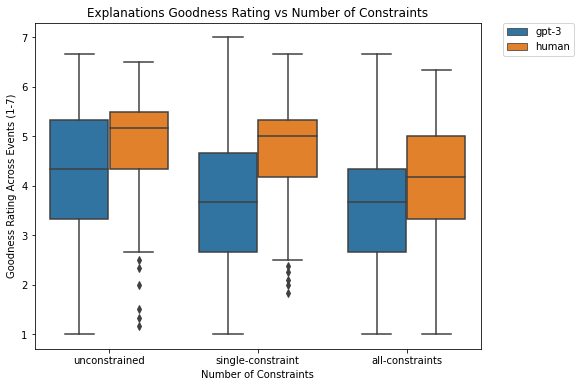

In [20]:
ratings = []
data = grouped_data
for constraint in constraints:
    for source in grouped_data:
        for generation_data in grouped_data[source][constraint]:
            row = [constraint, source, generation_data["mean"]]
            ratings.append(row)
    
rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df)
ax.set(ylabel='Goodness Rating Across Events (1-7)', title='Explanations Goodness Rating vs Number of Constraints')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)                                         
                                           

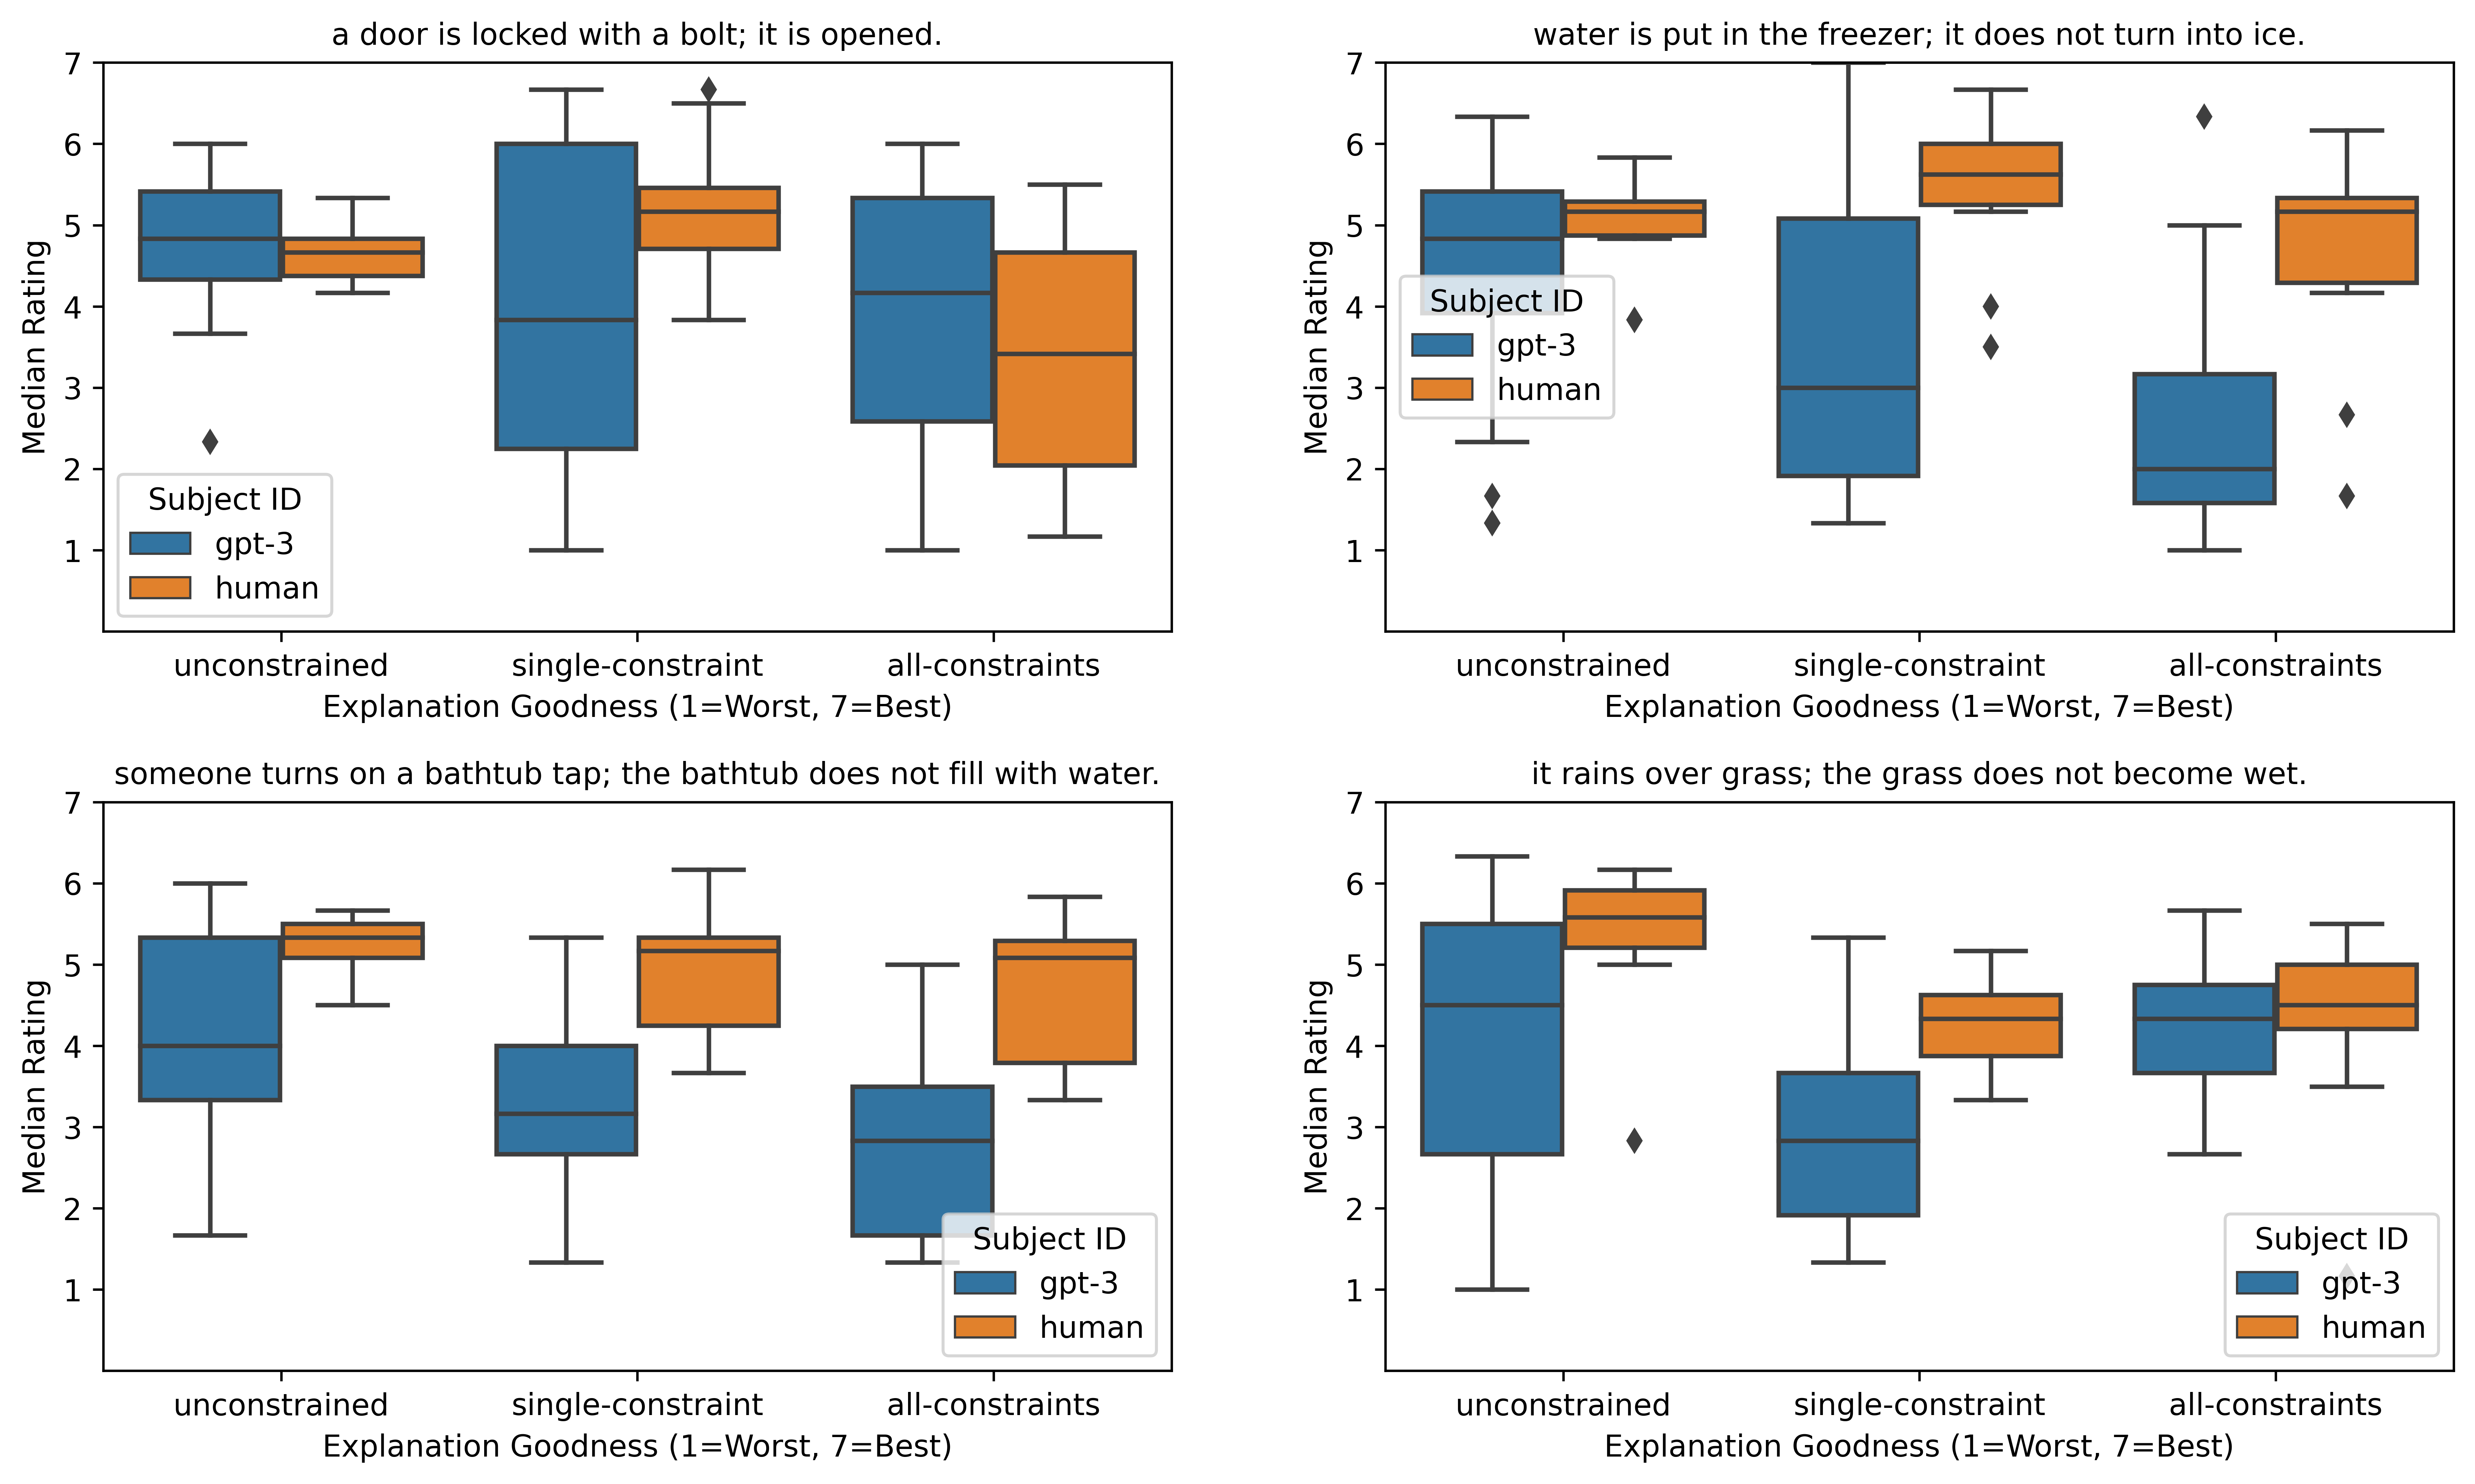

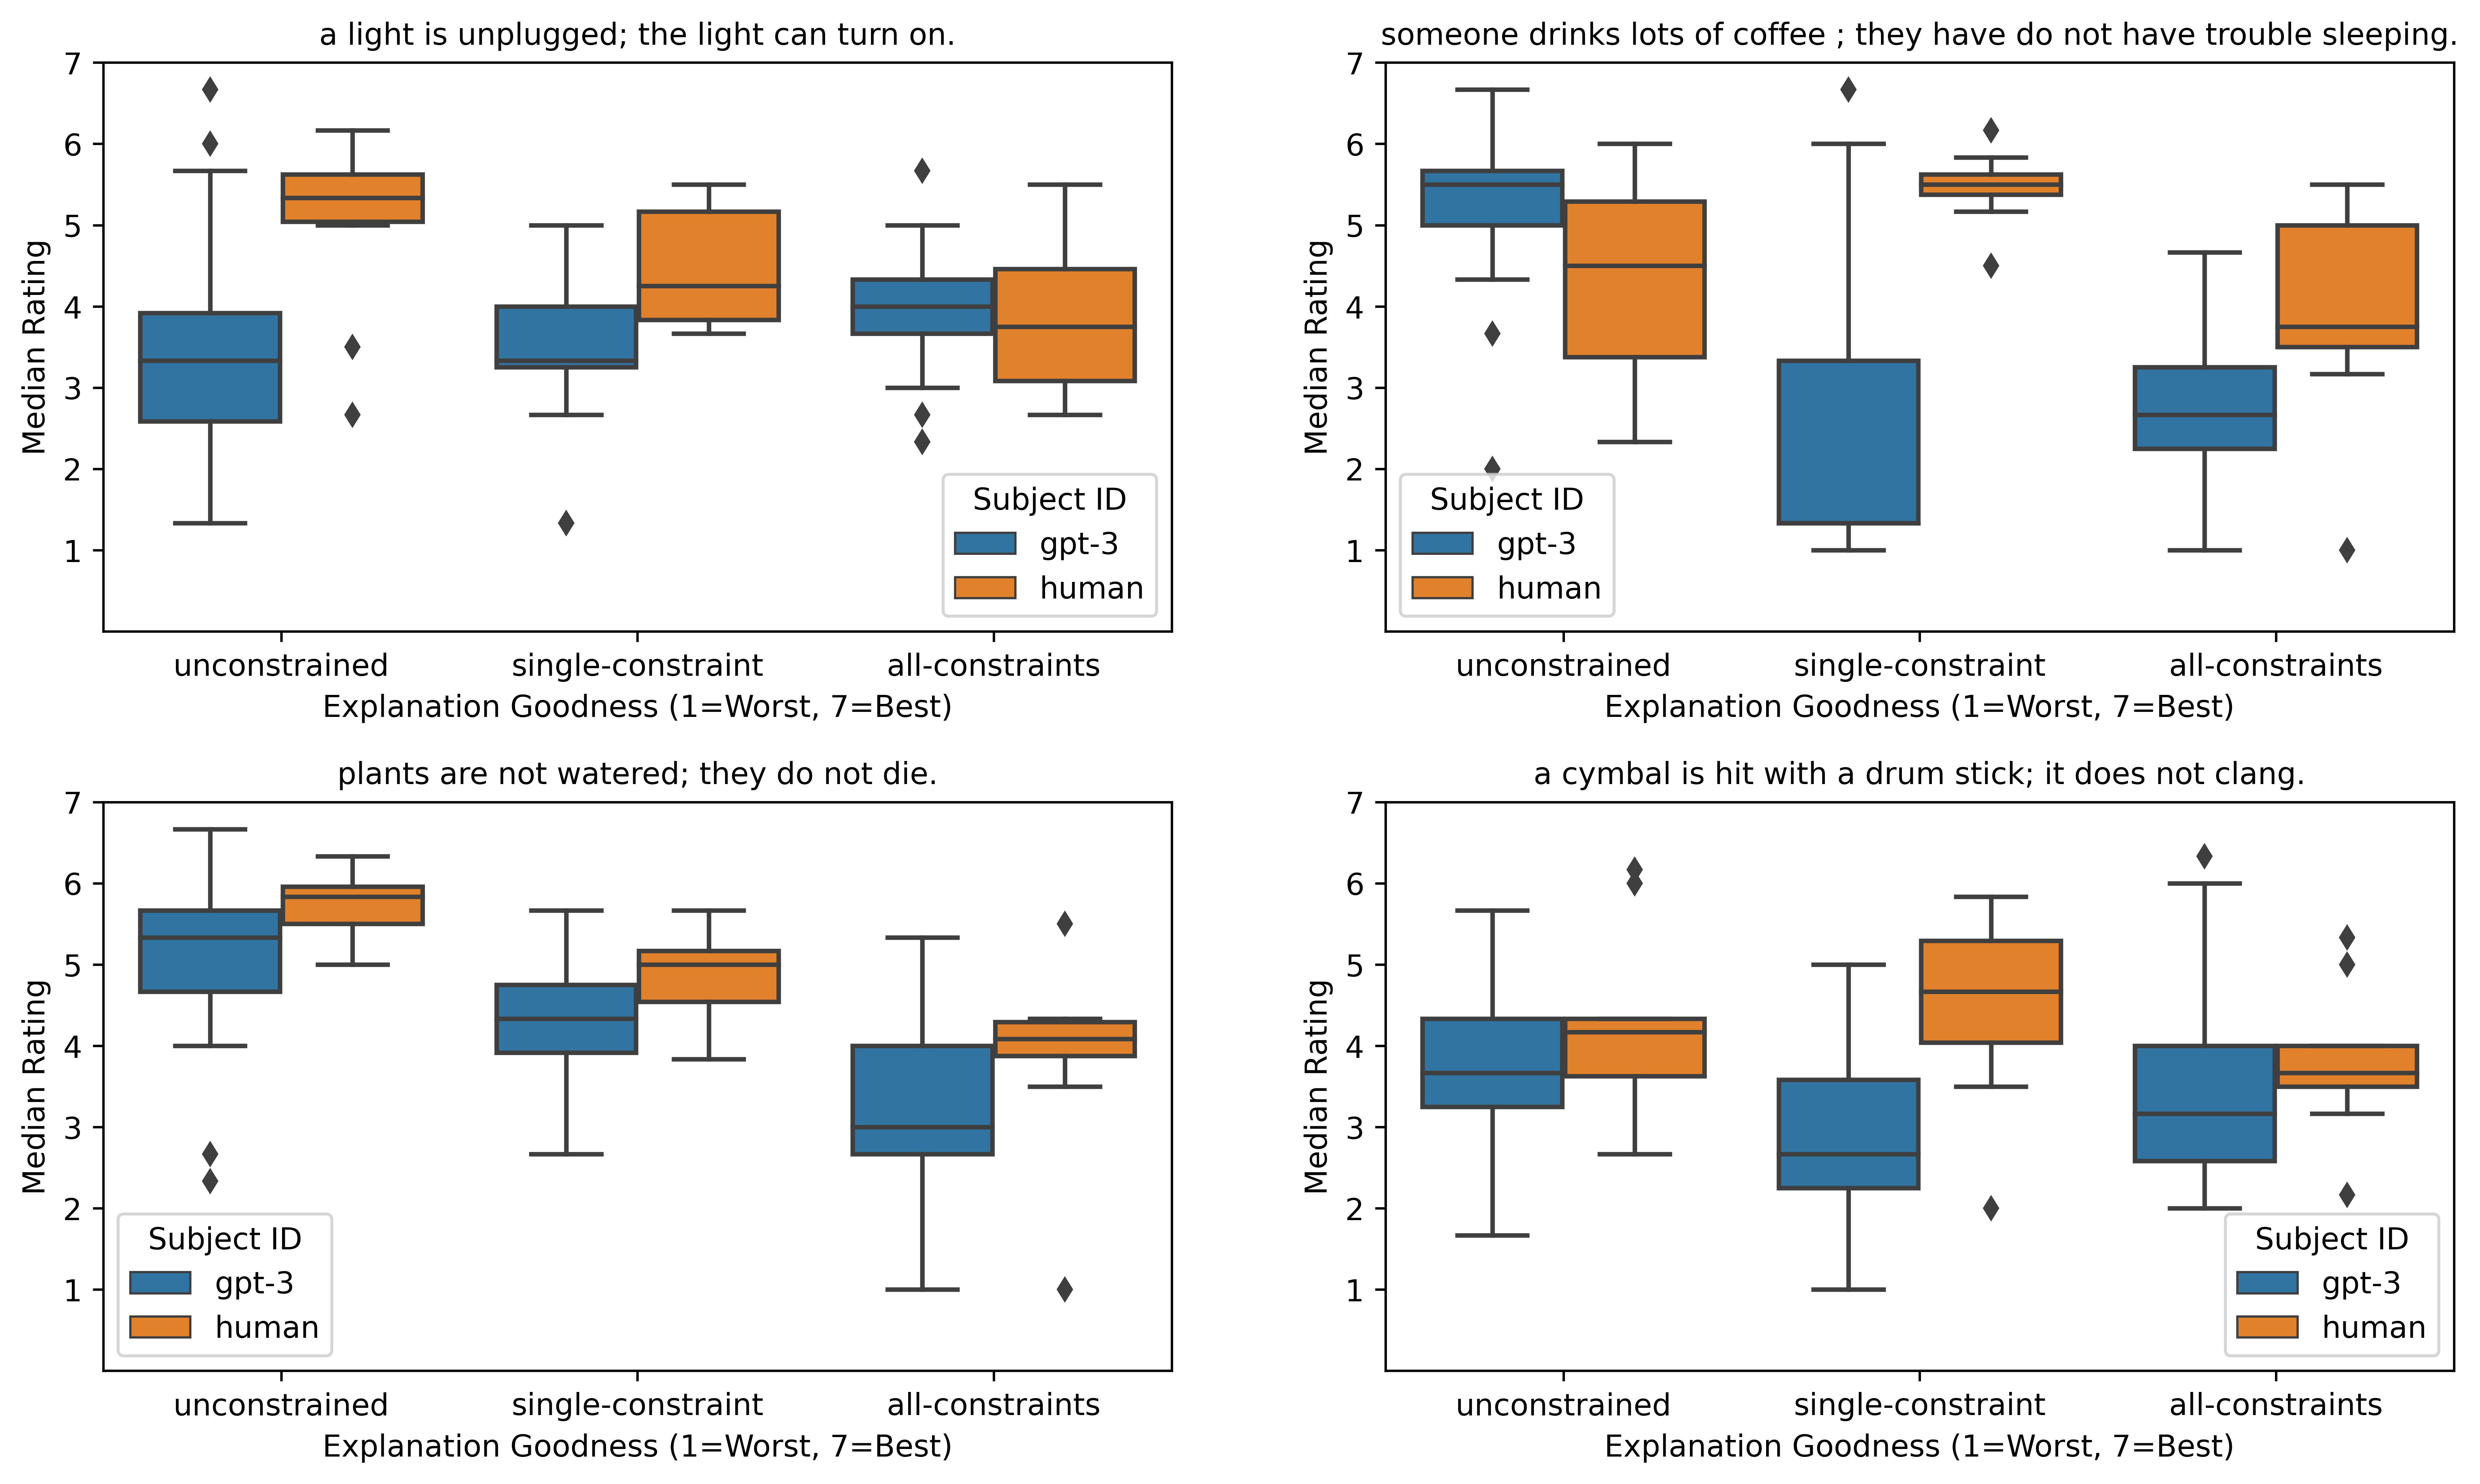

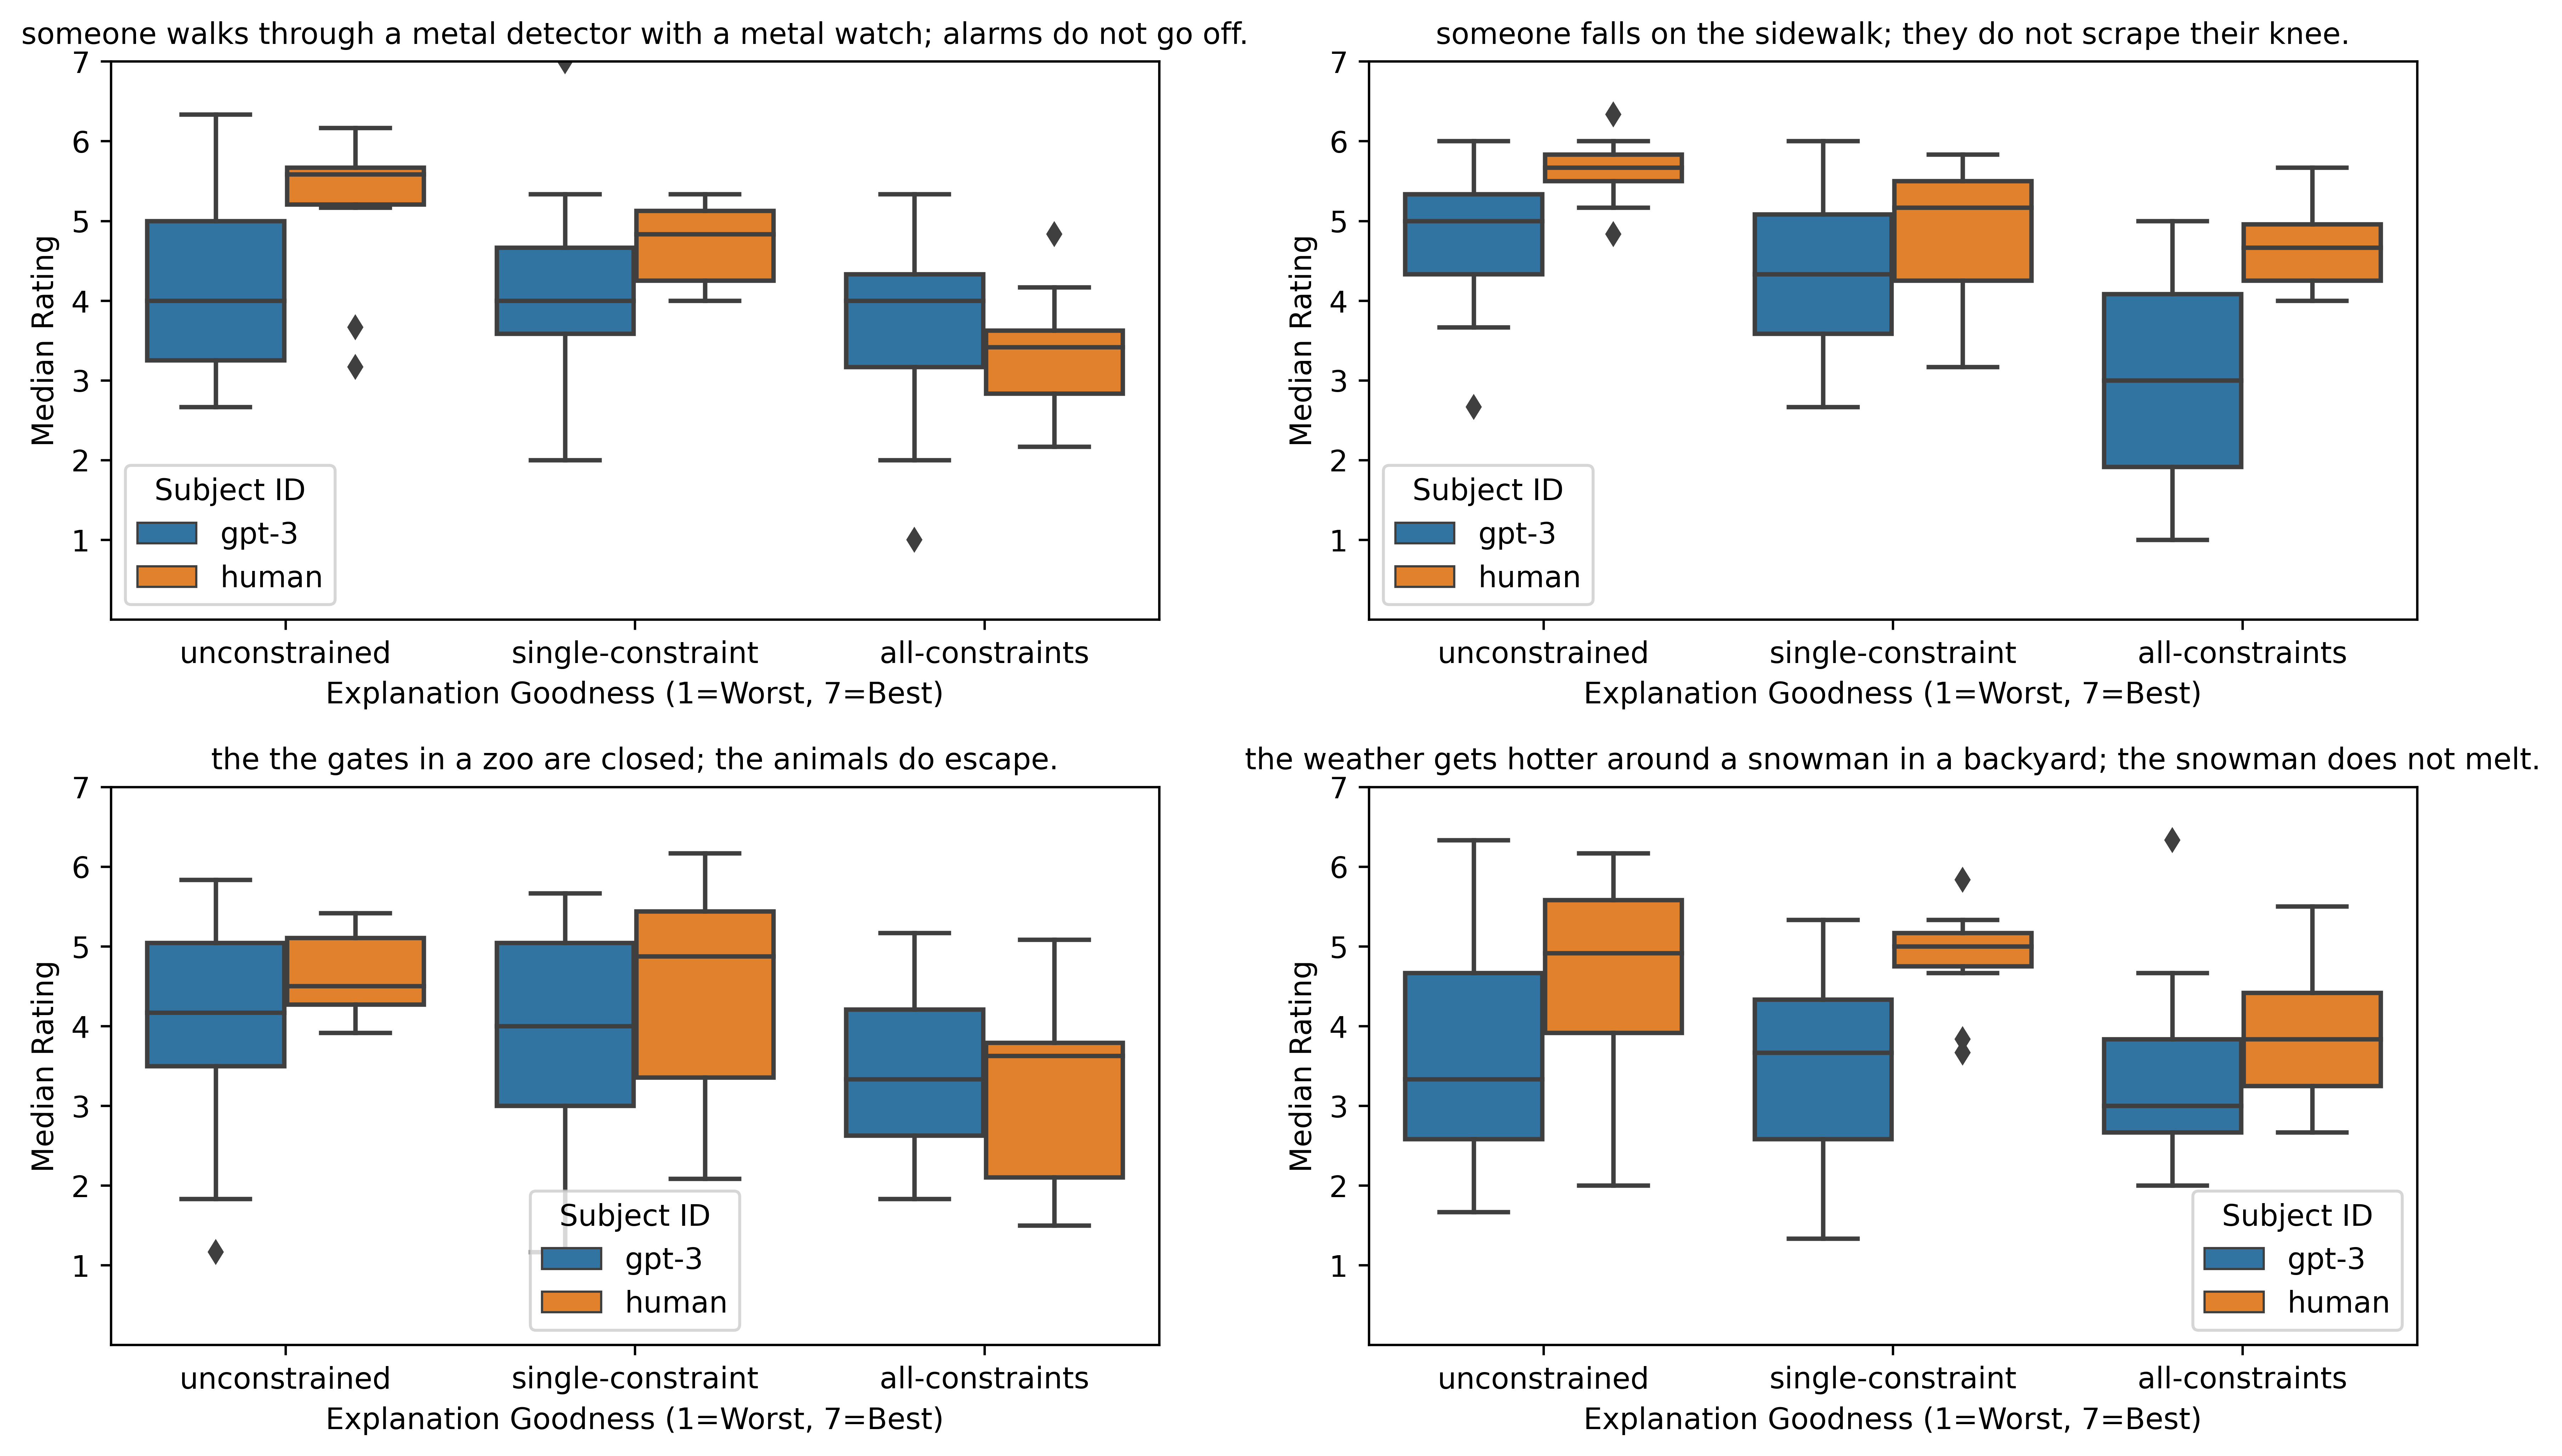

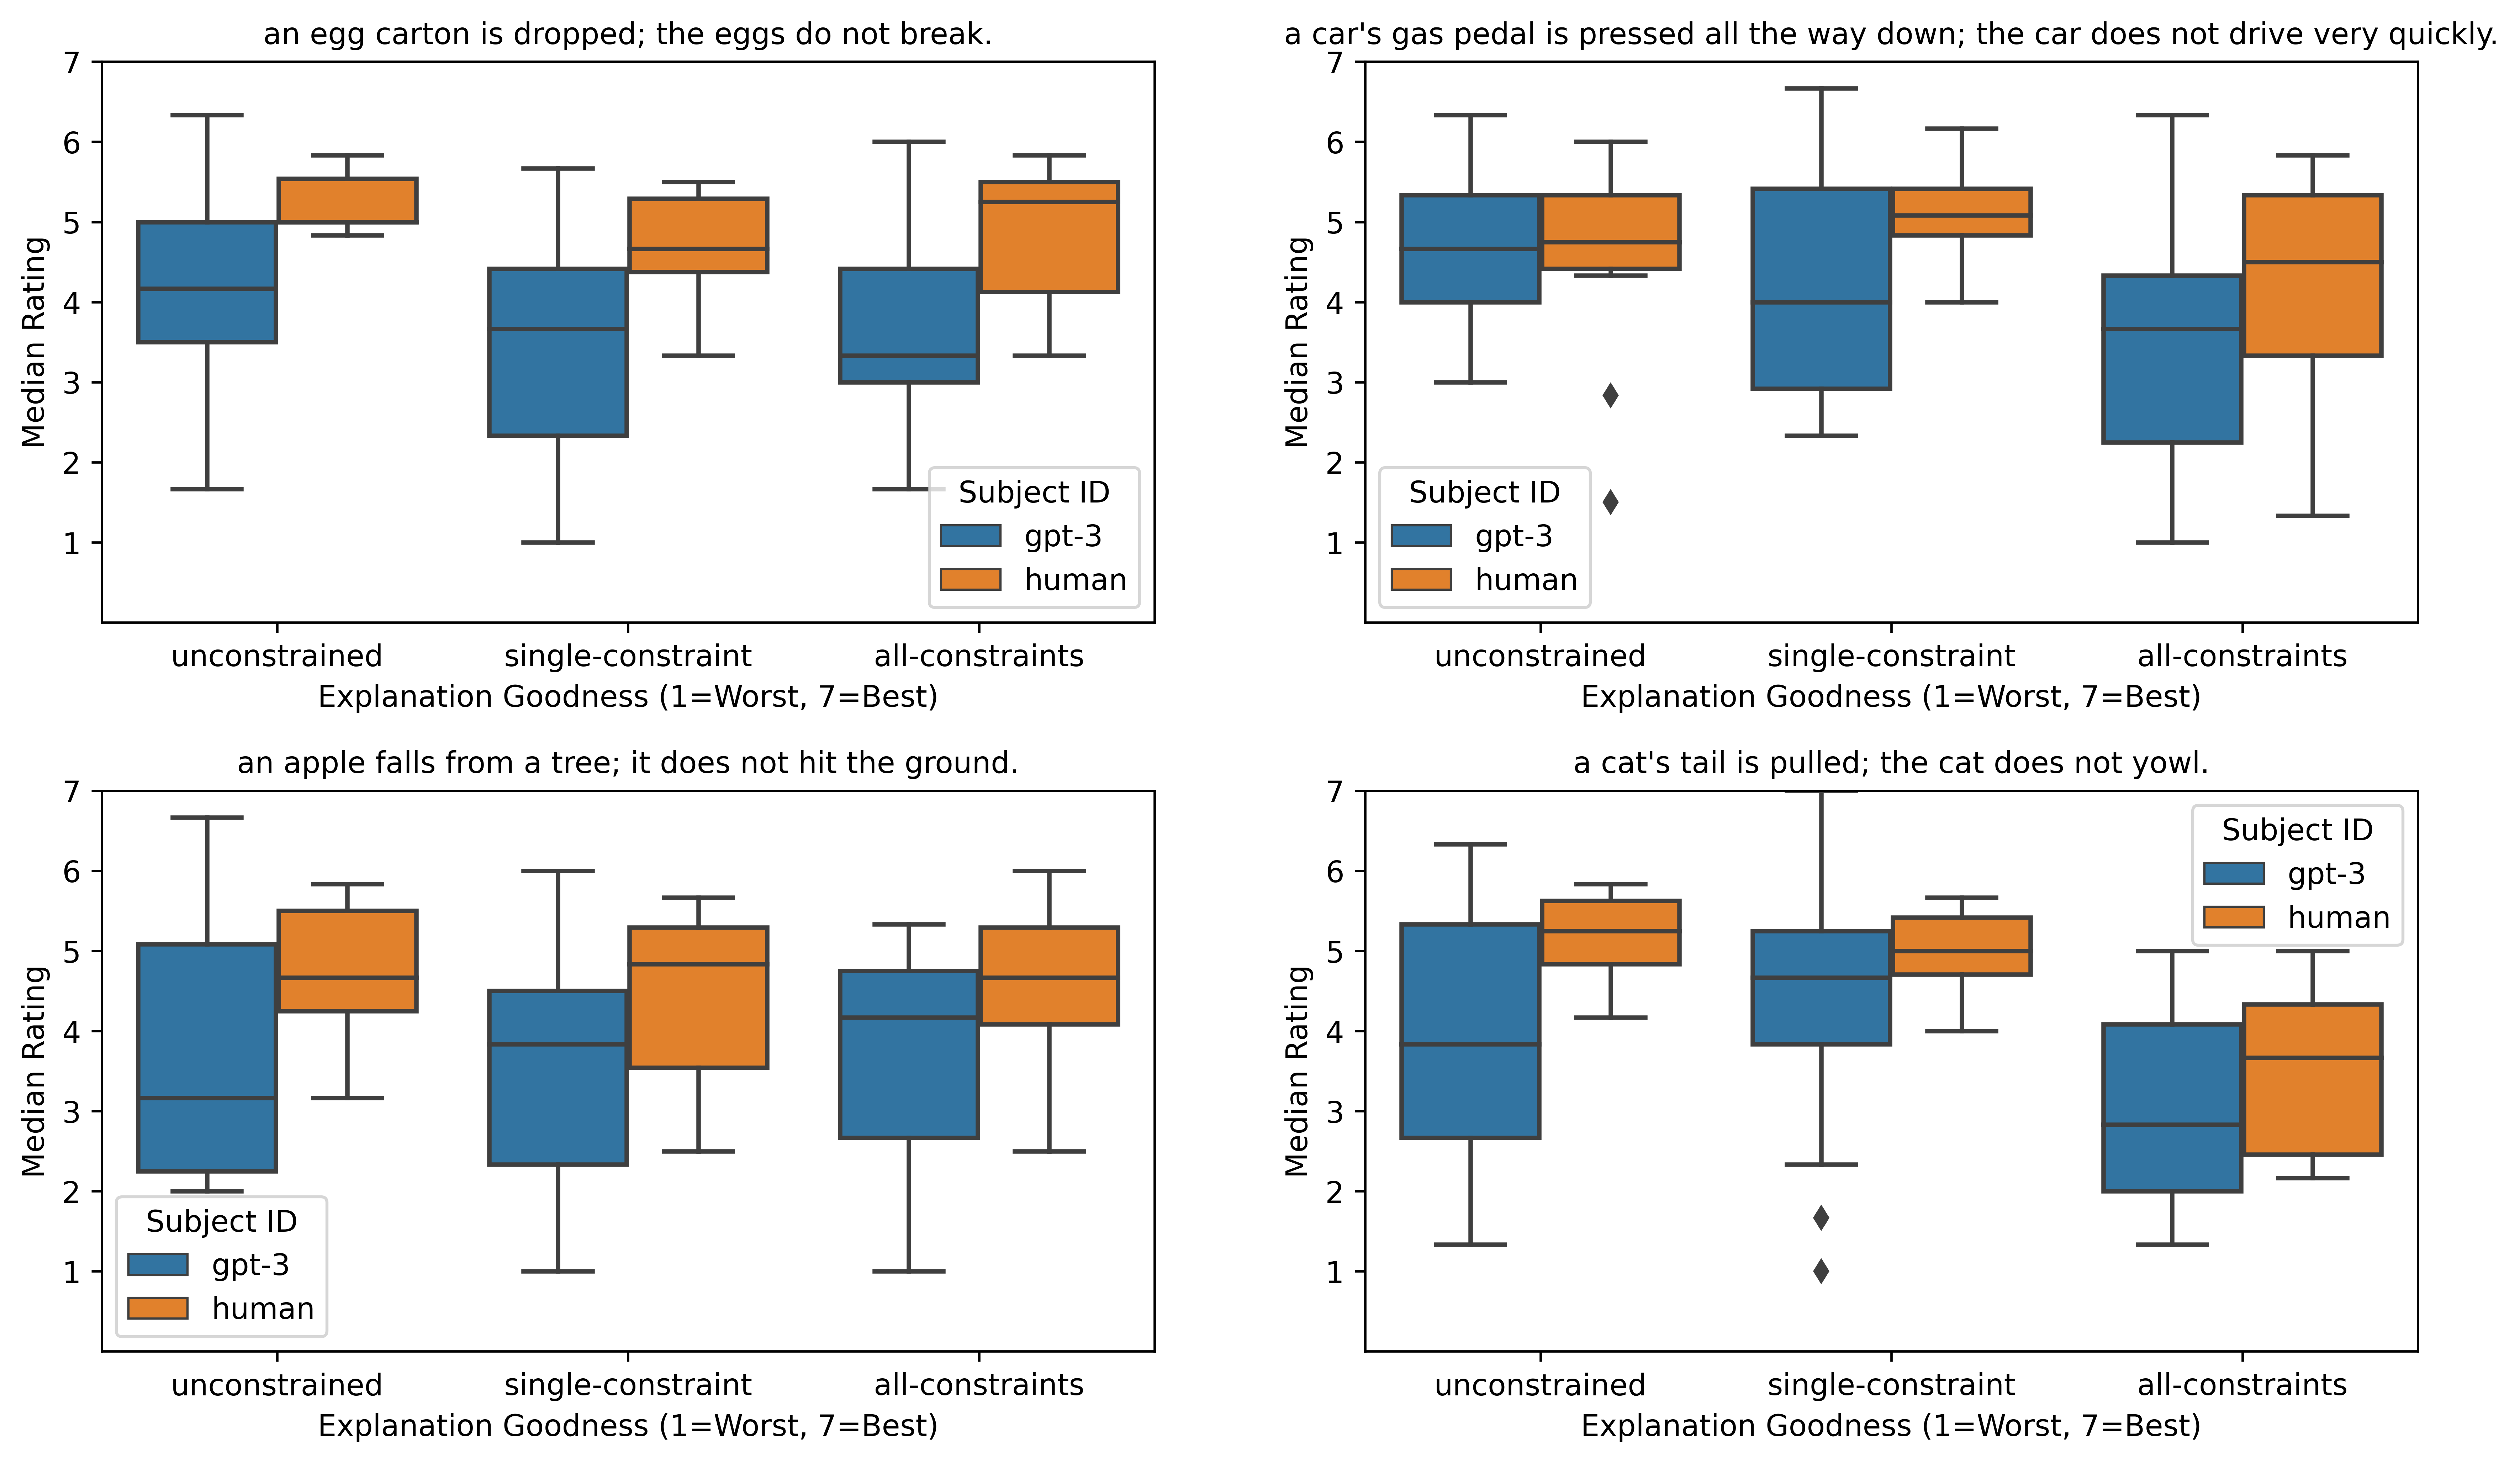

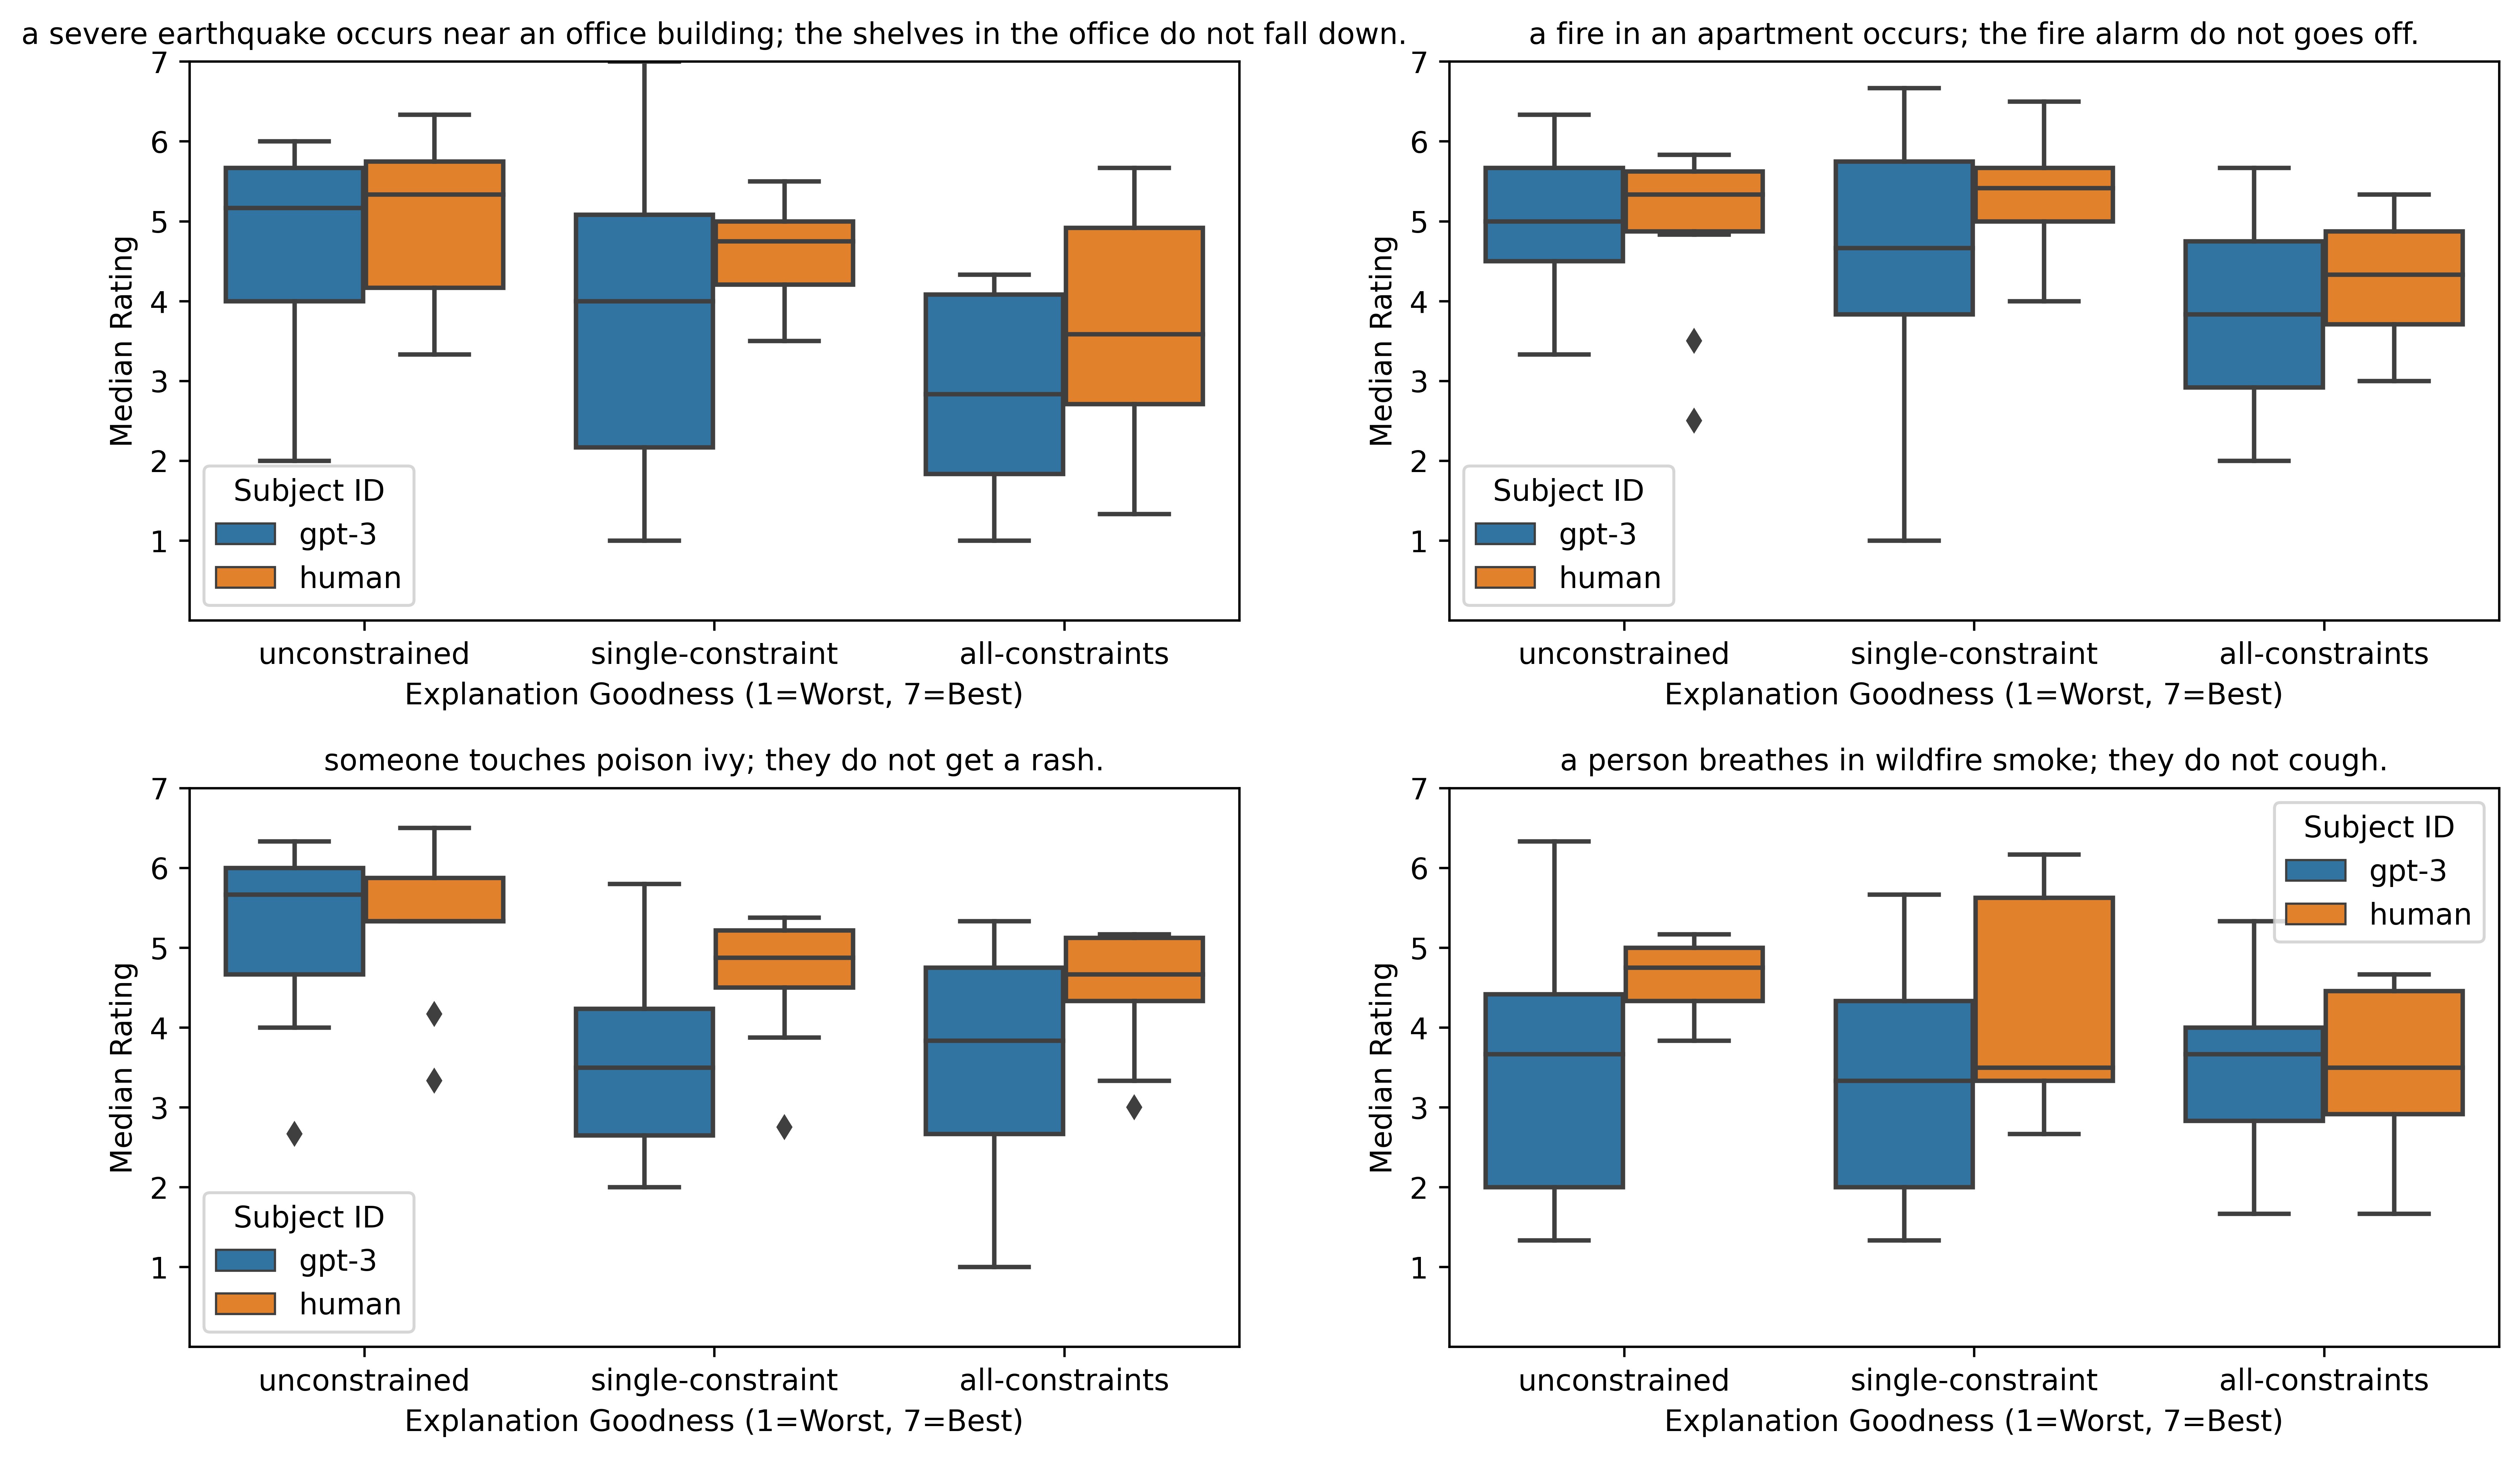

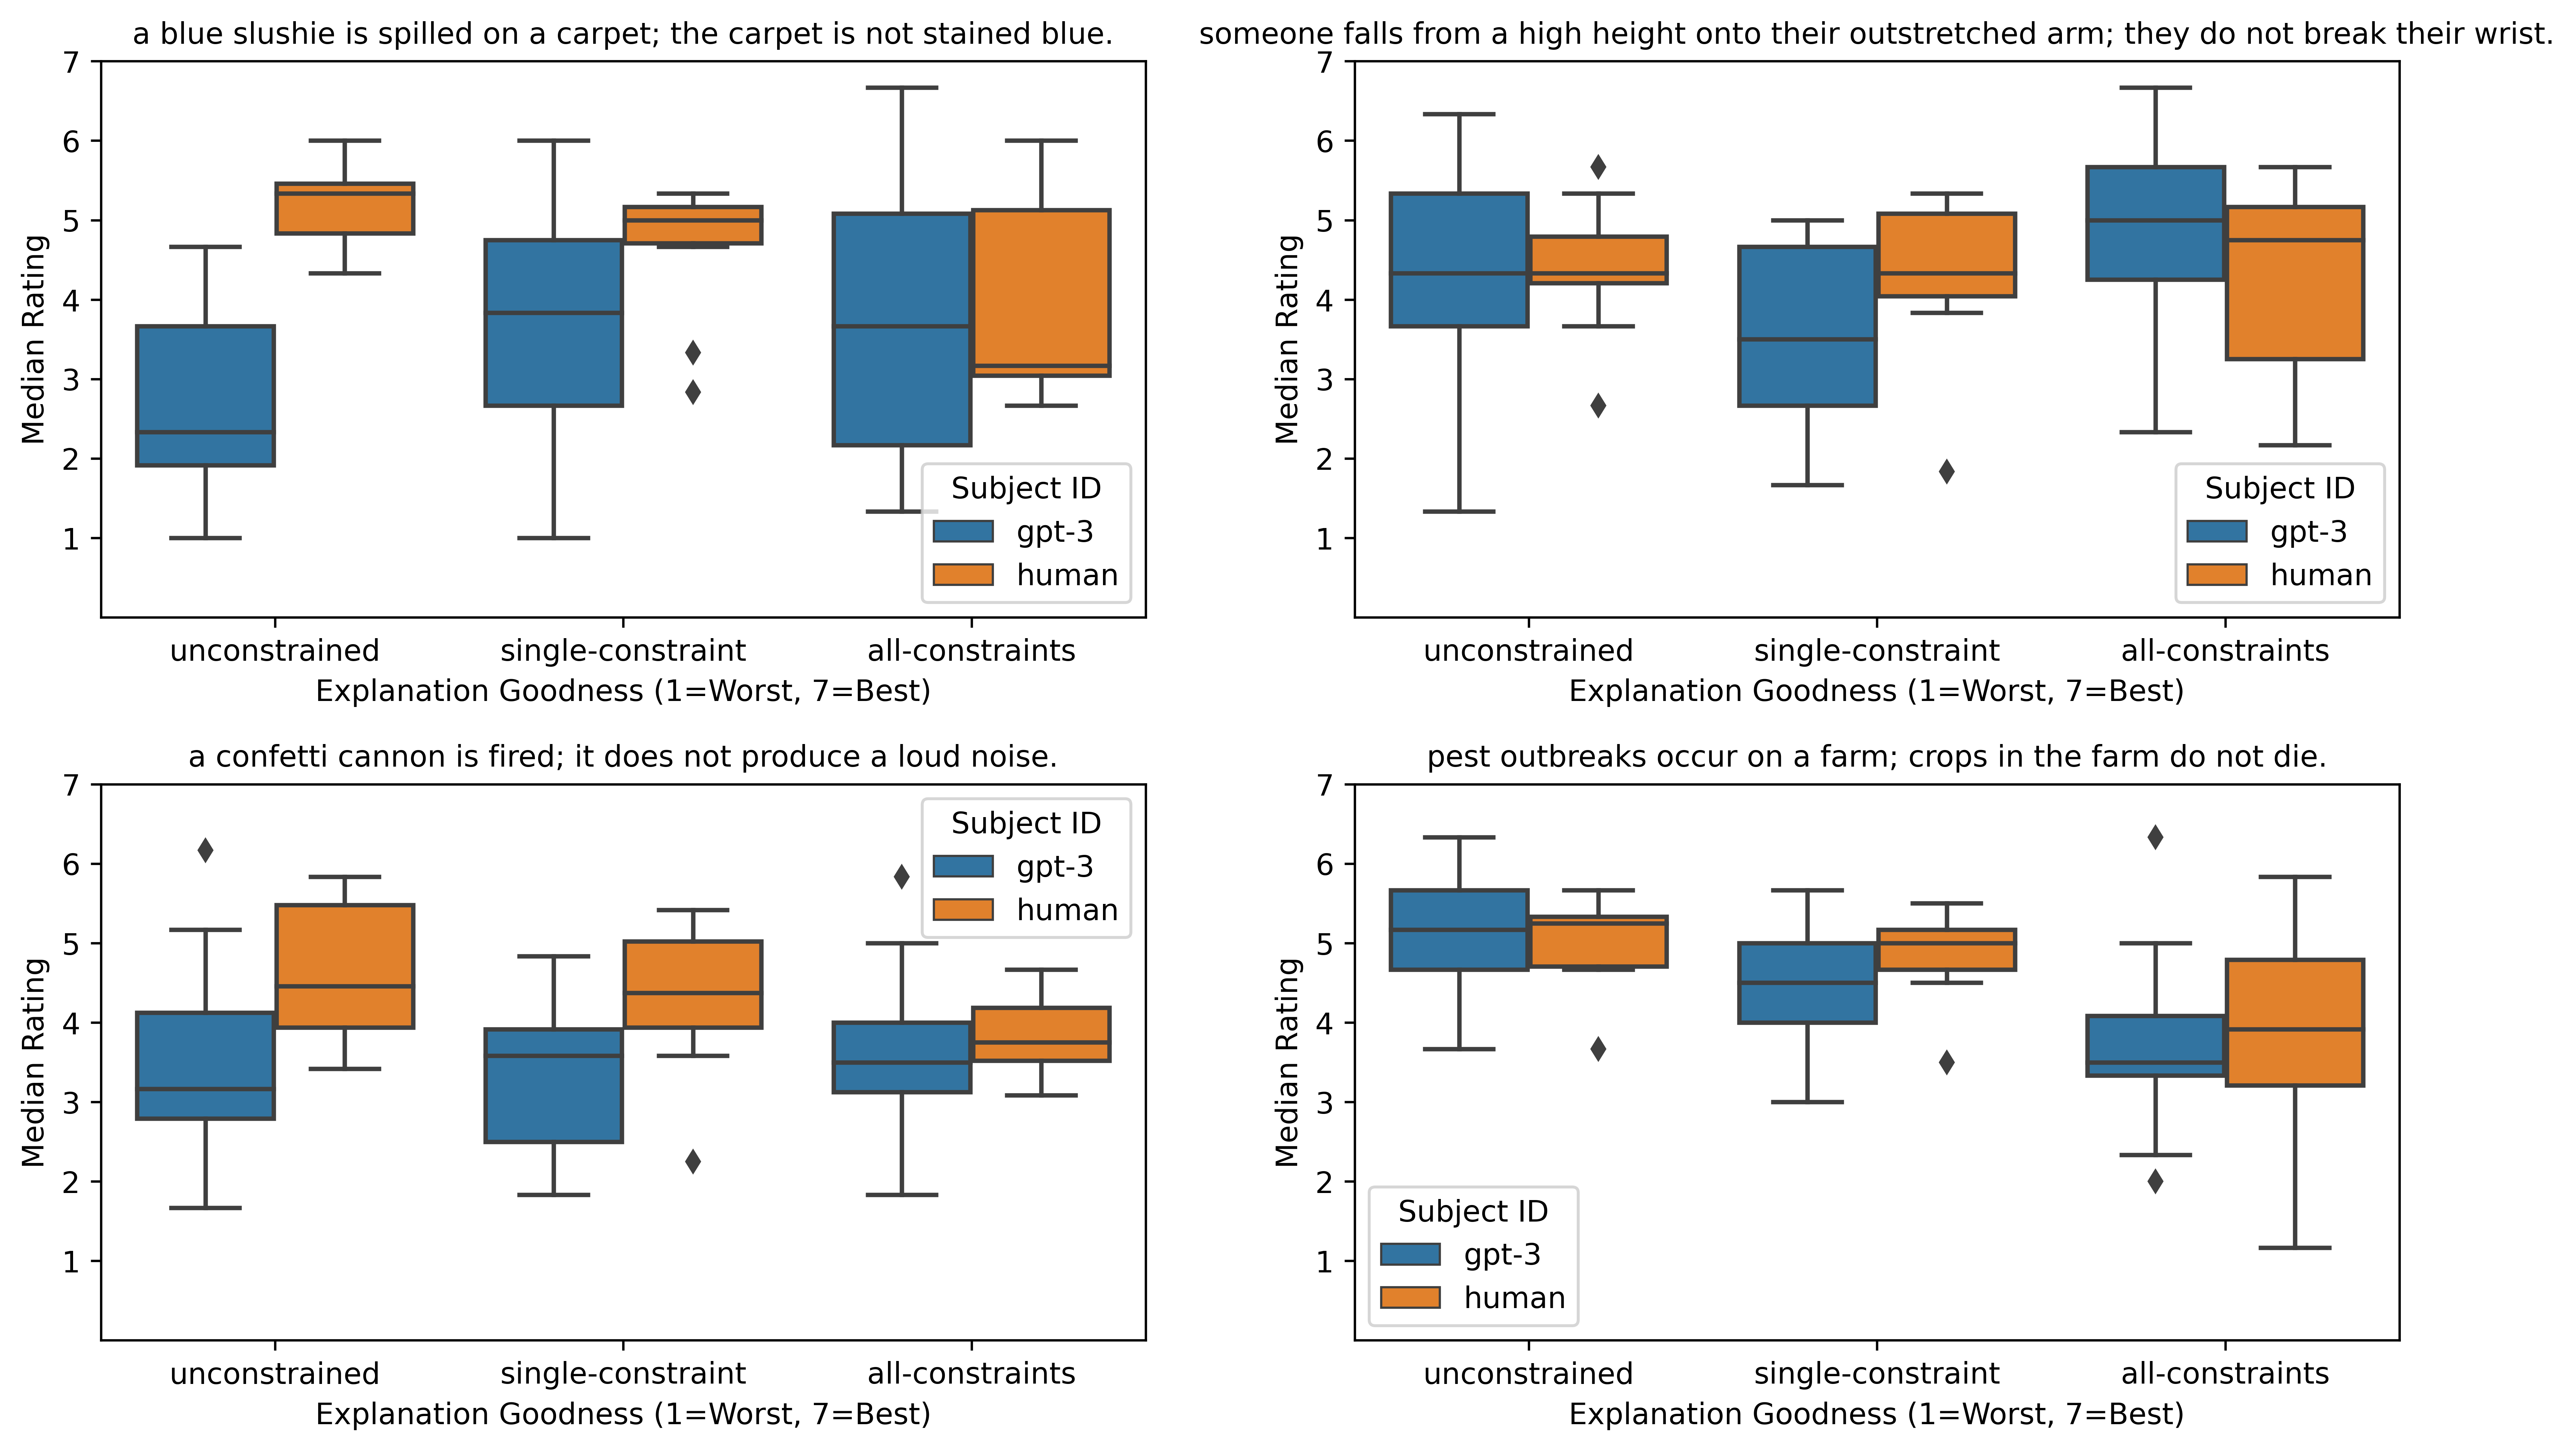

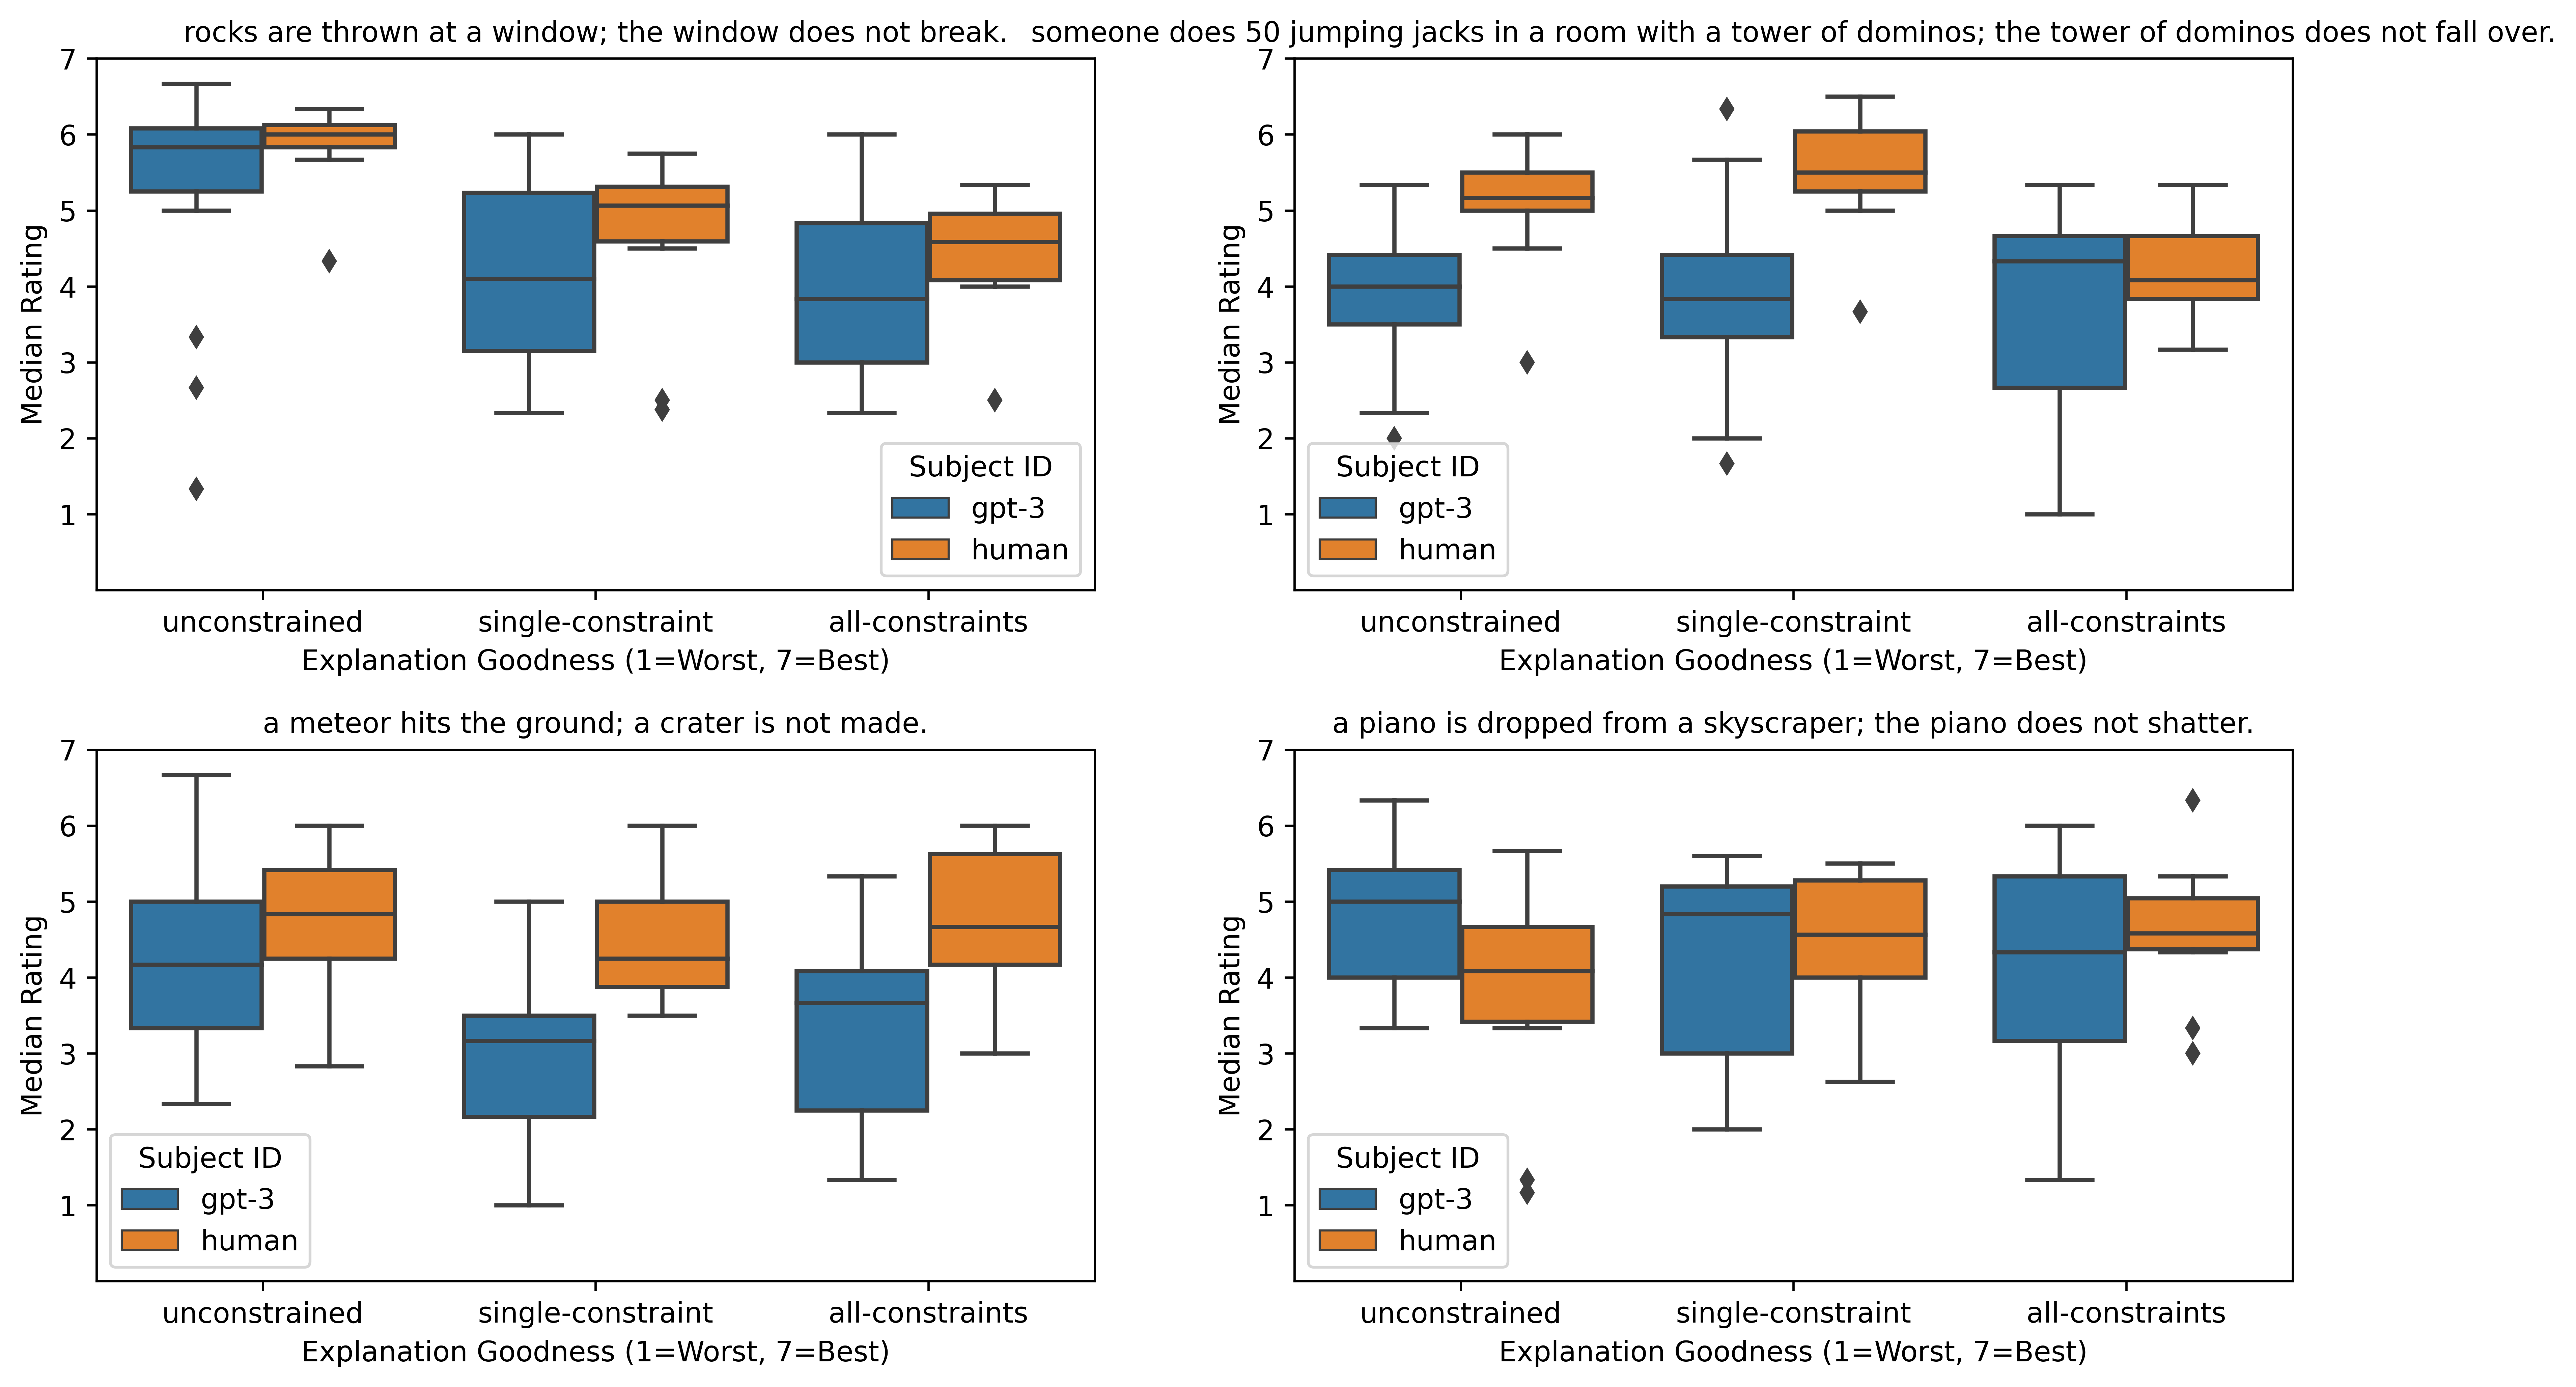

In [23]:
# plot goodness broken down by stimuli
# 28 stimuli in total - show 4 per page
n_stimuli = 28
cols = 2 
rows = 2 

# based on likert scale
max_y = 7 # showing rating on a scale of 1 to 7

pdf_pth = f'{save_dir}/per_stimuli_goodness.pdf'
    
# stims = np.array(stimuli_per_cond["unconstrained"]).reshape([int(n_stimuli/(rows * cols)), rows, cols])
stims = np.array(sorted_goals).reshape([int(n_stimuli/(rows * cols)), rows, cols])

with PdfPages(pdf_pth) as pdf:
    for stim_batch in stims: 
        f = plt.figure(figsize=(14, 8), dpi=600)
        gs0 = gridspec.GridSpec(rows, cols, figure=f,
                               wspace=0.2, hspace=0.3)
        for i in range(rows): 
            for j in range(cols): 
                stim_name = stim_batch[i][j]
#                 stim_fragment = stim_name.split("Scenario: ")[1] # consistent portion across goal types
                stim_fragment = stim_name
                ax = f.add_subplot(gs0[i, j])
                
                ratings = []
                data = grouped_data
                for constraint in constraints:
                    for source in grouped_data:
                        for generation_data in grouped_data[source][constraint]:
                            if stim_fragment in generation_data["stimuli"]: 
                                row = [constraint, source, generation_data["mean"]]
                                ratings.append(row)

                rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

                sns.boxplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df,
                                ax=ax)
#                 plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
#                 sns.barplot(x="dimension", y="rating", hue="source", 
#                             data=show_df, 
#                             ci=None, ax = ax)
                ax.set_ylim([0, max_y])
                ax.set_yticks([1,2,3,4,5,6,7])
                if_clause =  stim_fragment.split(", then")[0].split("If ")[-1]
                then_clause = stim_fragment.split("and then ")[1]
                title = f"{if_clause}; {then_clause}"
                ax.set_title(title, fontsize=10)
                
                ax.set_xlabel("Explanation Goodness (1=Worst, 7=Best)", fontsize=10)
#                 else: ax.set_xlabel("")
#                 if current_col == 1: 
#                     ax.set_ylabel("")
                ax.set_ylabel("Median Rating", fontsize=10)
                
        pdf.savefig()

In [ ]:
stim_batch

In [ ]:
# # plot goodness broken down by stimuli
# # 28 stimuli in total - show 4 per page
# cols = 2 
# rows = 2 

# # based on likert scale
# max_y = 7 # showing rating on a scale of 1 to 7


# for constraint in constraints: 

#     pdf_pth = f'{save_dir}/{constraint}_per_stimuli_goodness.pdf'
    
#     stims = np.array(stimuli_per_cond[constraint])

#     with PdfPages(pdf_pth) as pdf:
#         for stim_batch in stims: 
#             f = plt.figure(figsize=(14, 8), dpi=600)
#             gs0 = gridspec.GridSpec(rows, cols, figure=f,
#                                    wspace=0.1, hspace=1.0)
#             for i in range(rows): 
#                 for j in range(cols): 
#                     stim_name = stim_batch[i][j]
#                     ax = f.add_subplot(gs0[current_row, current_col])
#                     show_df = rating_df[rating_df.goal==stim_name]
#                     sns.barplot(x="dimension", y="rating", hue="source", 
#                                 data=show_df, 
#                                 ci=None, ax = ax)
#                     ax.set_ylim([0, max_y])
#                     ax.set_yticks([1,2,3,4,5,6,7])
#                     title = stim_name.split("Scenario: ")[1]
#                     ax.set_title(title, fontsize=8#12)
#                     if i == : 
#                         ax.set_xlabel("Explanation Goodness (1=Worst, 7=Best)", fontsize=10)
#                     else: ax.set_xlabel("")
#                     if current_col == 1: 
#                         ax.set_ylabel("")
#                     else: 
#                         ax.set_ylabel("Median Rating", fontsize=10)
#                     current_col += 1
#             pdf.savefig()

# Distribution of Goodness Ratings Plots

### Plots for goodness ratings, with 1 standard deviation error bars

In [ ]:
ratings = []
for constraint in constraints:
    for k in rating_data:
        for rating in rating_data[k][constraint]['ratings']:
            row = [constraint, k, rating]
            ratings.append(row)
    
rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df, ci='sd')
ax.set(ylabel='Goodness Rating Across Events (1-7)', title='Explanations Goodness Rating vs Number of Constraints')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                                           
                                           

### Boxen plots for goodness ratings

In [ ]:
ratings = []
for constraint in constraints:
    for k in rating_data:
        for rating in rating_data[k][constraint]['ratings']:
            row = [constraint, k, rating]
            ratings.append(row)
    
rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

ax = sns.boxenplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df)
ax.set(ylabel='Goodness Rating Across Events (1-7)', title='Explanations Goodness Rating vs Number of Constraints')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)                                           
                                           

### Box plots for goodness ratings

In [ ]:
ratings = []
for constraint in constraints:
    for k in rating_data:
        for rating in rating_data[k][constraint]['ratings']:
            row = [constraint, k, rating]
            ratings.append(row)
    
rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

ax = sns.boxplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df)
ax.set(ylabel='Goodness Rating Across Events (1-7)', title='Explanations Goodness Rating vs Number of Constraints')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)                                         
                                           

# Mean goodness ratings plots

In [ ]:
ratings = []
for constraint in constraints:
    for k in rating_data:
        row = [constraint, k, rating_data[k][constraint]["mean"]]
        ratings.append(row)
    
rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

ax = sns.barplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df)
ax.set(ylabel='Goodness Rating Averaged Across Events (1-7)', title='Explanations Mean Goodness Rating vs Number of Constraints')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                                           
                                           

# Median goodness ratings plots

In [ ]:
ratings = []
for constraint in constraints:
    for k in rating_data:
        row = [constraint, k, rating_data[k][constraint]["median"]]
        ratings.append(row)
    
rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])

ax = sns.barplot(x='Number of Constraints', y='Rating', hue='Subject ID', data=rating_df, ci='sd')
ax.set(ylabel='Median Goodness Rating Across Events (1-7)', title='Explanations Median Goodness Rating vs Number of Constraints')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                                           

# Distribution of Goodness Ratings

In [ ]:
for k in rating_data:
    for constraint in constraints:
        dist = rating_data[k][constraint]["ratings"]
        
        sns.set_theme(style="whitegrid")
        plt.figure()
        
        ax = sns.displot(dist, bins=7)
        ax.set(xlabel="Goodness Rating", title=f'Explanations Goodness Rating Distribution for {k} with constraint: {constraint}')

        plt.show()


In [ ]:
pd.DataFrame.from_dict(rating_data)